# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [3]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [4]:
## load dataset here
df = pd.read_csv("../data/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [5]:
## parsing data here
images, labels = parse_data(df)

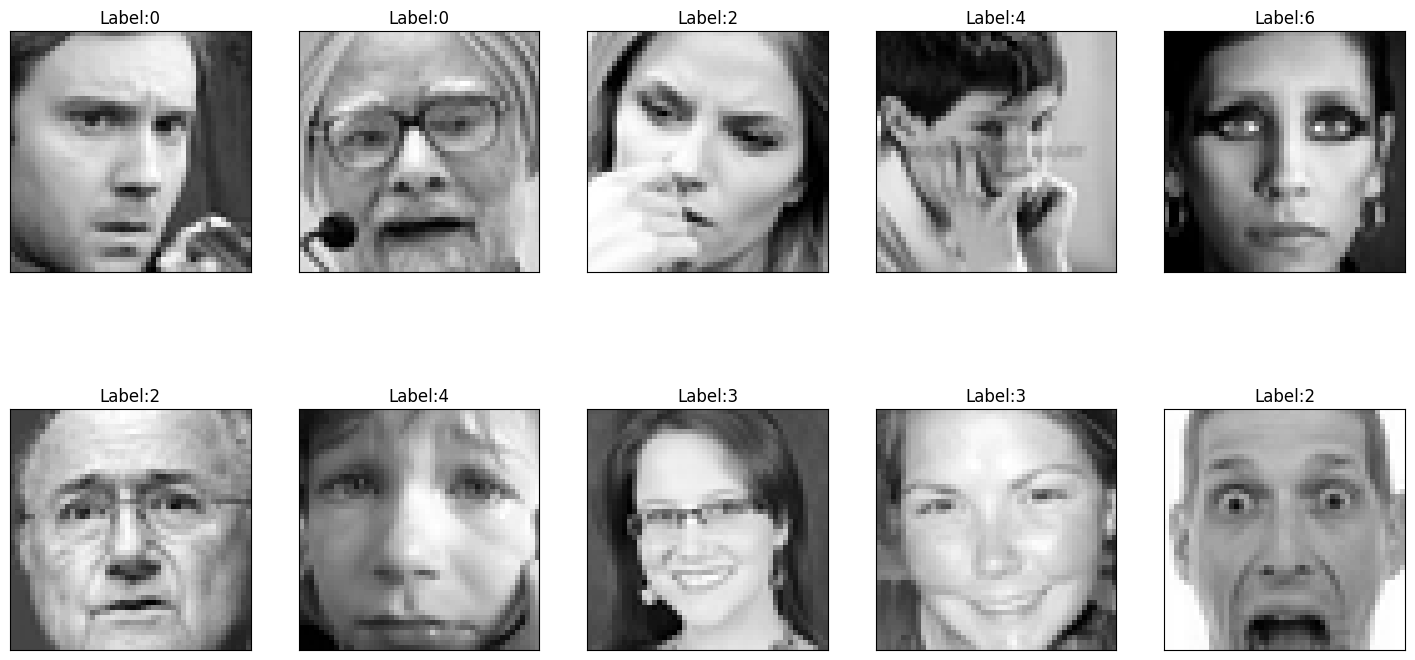

In [6]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

```Answer:```
We can visualize the data that has been projected onto the 2 principal components. However, because the total variance explained by 38.45% is a low number, less than 50%, this proves that it only shows and summarizes 38.45% of the original information in data. Therefore, the visualization is possible but the results are not good, with a rate lower than 50%, we cannot fully grasp the aspects and most of the information in the original data. We need to increase n_components to have a reliable ratio.

In [7]:
images = images.reshape(len(images), -1)
images.shape

(35887, 2304)

In [8]:
# Normalize pixel values to be between 0 and 1
images = images / 255.0

In [9]:
from sklearn import preprocessing

# using RobustScaler() to remove the outliers
scaler = preprocessing.RobustScaler()
robust = scaler.fit_transform(images)
robust_df = pd.DataFrame(robust)

# Standardize features
scaler = preprocessing.StandardScaler()
standard = scaler.fit_transform(robust_df)
standard_df = pd.DataFrame(standard, index=df.index)

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(standard_df)

PCA(n_components=2)

In [11]:
# transform for visualizing here
images_pca = pca.transform(standard_df)
images_pca.shape

(35887, 2)

In [12]:
# calculate total variance explained to see how effective the principal components in summarizing the dataset
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio)
print("Total variance explained by 2 components:", np.sum(explained_variance_ratio))

Explained variance ratio: [0.2914515  0.09307258]
Total variance explained by 2 components: 0.3845240729448598


Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

```Answer:``` In order to get the smallest number (optimal number) of components for PCA that still capture most of the information in the datasets. I use the method ```pca.explained_variance_ratio_```, this method will return the percentage of variance explained by each of the principal components from 1 to the rank of the dataset. In addition, by utilizing ```np.cumsum```, I can add up each of the variance per component until it reaches 100% for the final component. 

The common approach is to pick enough components to cover about 95% of the total data variance.


Number of components explaining 95% variance: 269


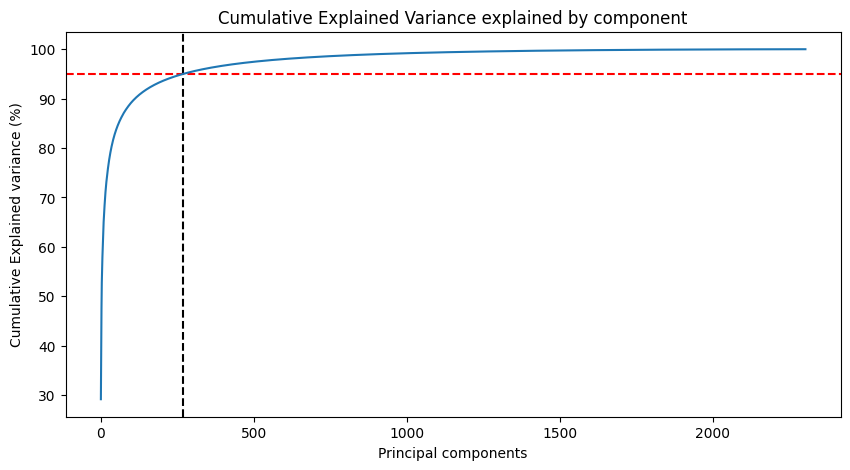

In [13]:
pca = PCA()
pca.fit(standard_df)

# Getting the cumulative variance
var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
number_components = np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: "+ str(number_components))

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by component')
plt.ylabel('Cumulative Explained variance (%)')
plt.xlabel('Principal components')
plt.axvline(x=number_components, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)

In [14]:
pca = PCA(n_components=number_components)
pca.fit(images)
images_pca_2 = pca.transform(images)

In [15]:
images_pca_2.shape

(35887, 269)

In [16]:
# calculate total variance explained to see how effective the principal components in summarizing the dataset
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Total variance explained by {number_components} components:", np.sum(explained_variance_ratio))

Total variance explained by 269 components: 0.9520564628257022


## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [17]:
## splitting data into train/val/test subsets here

from sklearn.model_selection import train_test_split
RANDOM_STATE = 42
TRAIN_SIZE = 0.8

trainX, testX ,trainY, testY = train_test_split(images, labels, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)
trainX2, testX2 ,trainY2, testY2 = train_test_split(images_pca_2, labels, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC  
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

In [19]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 159)

### KNeighborsClassifier

#### Scores with the default param

In [159]:
knn = KNeighborsClassifier()
scores = cross_val_score(knn, trainX, trainY, scoring='accuracy', cv=folds)
scores    

array([0.3241031 , 0.31783351, 0.31156392, 0.3159178 , 0.32468211])

In [160]:
knn = KNeighborsClassifier()
scores = cross_val_score(knn, trainX2, trainY2, scoring='accuracy', cv=folds)
scores    

array([0.33106931, 0.32218739, 0.31940091, 0.3256705 , 0.32903675])

#### Doing hyperparameter optimization

In [163]:
k_range = list(range(1, 20, 2))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)
gridsearch = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring="accuracy", verbose=1)

In [164]:
gridsearch.fit(trainX, trainY)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [166]:
print(gridsearch.best_score_)
print(gridsearch.best_params_)

0.37113802707625726
{'n_neighbors': 3, 'weights': 'distance'}


In [167]:
gridsearch.fit(trainX2, trainY2)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [168]:
print(gridsearch.best_score_)
print(gridsearch.best_params_)

0.38057763515301246
{'n_neighbors': 3, 'weights': 'distance'}


#### Scores after finding the optimal params for model

In [171]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
scores = cross_val_score(knn, trainX, trainY, scoring='accuracy', cv=folds)
print(scores)
print("Best Value:", max(scores))    

[0.36624869 0.37460815 0.3712992  0.36276559 0.37310573]
Best Value: 0.37460815047021945


In [172]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
scores = cross_val_score(knn, trainX2, trainY2, scoring='accuracy', cv=folds)
print(scores)
print("Best Value:", max(scores))    

[0.37652386 0.38209683 0.37513062 0.37408568 0.38146664]
Best Value: 0.38209683037269243


### RandomForestClassifier

#### Scores with the default param

In [173]:
rf = RandomForestClassifier()
scores = cross_val_score(rf, trainX, trainY, scoring='accuracy', cv=folds)
scores  

array([0.44444444, 0.44740509, 0.4496691 , 0.44845002, 0.45183766])

In [174]:
rf = RandomForestClassifier()
scores = cross_val_score(rf, trainX2, trainY2, scoring='accuracy', cv=folds)
scores  

array([0.37878788, 0.38975967, 0.38018112, 0.37112504, 0.38390524])

#### Doing hyperparameter optimization

In [57]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

param_grid

{'n_estimators': [20, 65, 110, 155, 200],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [1, 23, 45],
 'min_samples_split': [5, 10]}

In [59]:
from sklearn.model_selection import RandomizedSearchCV

randomsearch = RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=2)

In [67]:
randomsearch.fit(trainX, trainY)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [1, 23, 45],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [20, 65, 110, 155,
                                                         200]},
                   scoring='accuracy', verbose=2)

In [68]:
print(randomsearch.best_score_)
print(randomsearch.best_params_)

0.4443205100471201
{'n_estimators': 200, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 45}


In [64]:
randomsearch.fit(trainX2, trainY2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [1, 23, 45],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [20, 65, 110, 155,
                                                         200]},
                   scoring='accuracy', verbose=2)

In [65]:
print(randomsearch.best_score_)
print(randomsearch.best_params_)

0.3845483494299174
{'n_estimators': 200, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 45}


#### Scores after finding the optimal params for model

In [69]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=10, max_features='sqrt', max_depth=45, n_jobs=-1)
scores = cross_val_score(rf, trainX, trainY, scoring='accuracy', cv=folds)
print(scores)
print("Best Value:", max(scores))

[0.45036573 0.44636015 0.45402299 0.44688262 0.4500958 ]
Best Value: 0.4540229885057471


In [66]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=10, max_features='sqrt', max_depth=45, n_jobs=-1)
scores = cross_val_score(rf, trainX2, trainY2, scoring='accuracy', cv=folds)
print(scores)
print("Best Value:", max(scores))

[0.38749565 0.40125392 0.38819227 0.38279345 0.40184637]
Best Value: 0.4018463682285316


### DecisionTreeClassifier

#### Scores with the default param

In [213]:
dt = DecisionTreeClassifier()
scores = cross_val_score(dt, trainX, trainY, scoring='accuracy', cv=folds)
scores  

array([0.30337861, 0.31034483, 0.30494601, 0.30494601, 0.31057307])

In [214]:
dt = DecisionTreeClassifier()
scores = cross_val_score(dt, trainX2, trainY2, scoring='accuracy', cv=folds)
scores  

array([0.27638454, 0.2979798 , 0.27882271, 0.28195751, 0.29123846])

#### Doing hyperparameter optimization

In [218]:
param_grid = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
gridsearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=3, scoring="accuracy", verbose=1)

In [219]:
gridsearch.fit(trainX, trainY)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [220]:
print(gridsearch.best_score_)
print(gridsearch.best_params_)

0.3069419824458545
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 100}


In [221]:
gridsearch.fit(trainX2, trainY2)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [222]:
print(gridsearch.best_score_)
print(gridsearch.best_params_)

0.2939146966036959
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 20}


#### Scores after finding the optimal params for model

In [223]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=100)
scores = cross_val_score(dt, trainX, trainY, scoring='accuracy', cv=folds)
print(scores)
print("Best Value:", max(scores))  

[0.30407524 0.31313131 0.30755834 0.2995472  0.3211984 ]
Best Value: 0.3211983974917262


In [224]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=20)
scores = cross_val_score(dt, trainX2, trainY2, scoring='accuracy', cv=folds)
print(scores)
print("Best Value:", max(scores))  

[0.29240683 0.29153605 0.29571578 0.28596308 0.3065668 ]
Best Value: 0.3065668002090228


### MLPClassifier

#### Scores with the default param

In [25]:
mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)
scores = cross_val_score(mlp, trainX, trainY, scoring='accuracy', cv=folds)
scores  

array([0.3354232 , 0.25548589, 0.30250784, 0.36415883, 0.37502177])

In [26]:
mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)
scores = cross_val_score(mlp, trainX2, trainY2, scoring='accuracy', cv=folds)
scores  

array([0.36346221, 0.37652386, 0.37739464, 0.37600139, 0.37502177])

#### Doing hyperparameter optimization

It take so much time to train by MLPClassifier model with entire training set, so I think of an idea to take just the sample of trainX and trainY from both original and transformed dataset. By generate random indices for subsampling, I can make sure to take the training dataset with the right label dataset.

In [300]:
from random import sample
import numpy as np

divisor = 10

# Generate random indices for subsampling
indices_trainX = sample(range(len(trainX)), k=len(trainX) // divisor)
indices_trainX2 = sample(range(len(trainX2)), k=len(trainX2) // divisor)

# Subsample trainX and trainY using the same set of indices
sample_trainX = trainX[indices_trainX]
sample_trainY = trainY[indices_trainX]

# Subsample trainX2 and trainY2 using the same set of indices
sample_trainX2 = trainX2[indices_trainX2]
sample_trainY2 = trainY2[indices_trainX2]


In [301]:
print("trainX.shape =", trainX.shape)
print("sample_trainX.shape =", sample_trainX.shape)
print("trainY.shape =", trainY.shape)
print("sample_trainX.shape =", sample_trainY.shape)

trainX.shape = (28709, 2304)
sample_trainX.shape = (2870, 2304)
trainY.shape = (28709,)
sample_trainX.shape = (2870,)


In [302]:
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant','adaptive'],
}
gridsearch = GridSearchCV(MLPClassifier(), param_grid, cv=3, scoring="accuracy", verbose=1)

In [303]:
gridsearch.fit(sample_trainX, sample_trainY)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=MLPClassifier(),
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             scoring='accuracy', verbose=1)

In [304]:
print(gridsearch.best_score_)
print(gridsearch.best_params_)

0.3222974223551341
{'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}


In [305]:
gridsearch.fit(sample_trainX2, sample_trainY2)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=MLPClassifier(),
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             scoring='accuracy', verbose=1)

In [306]:
print(gridsearch.best_score_)
print(gridsearch.best_params_)

0.3337967760129064
{'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}


#### Scores after finding the optimal params for model

In [308]:
mlp = MLPClassifier(activation='tanh', 
                    hidden_layer_sizes= (100,), 
                    learning_rate= 'constant', 
                    solver= 'sgd')
scores = cross_val_score(mlp, trainX, trainY, scoring='accuracy', cv=folds)
print(scores)
print("Best Value:", max(scores))

[0.39933821 0.40996169 0.40369209 0.40491118 0.40933635]
Best Value: 0.4099616858237548


In [307]:
mlp = MLPClassifier(activation='tanh', 
                    hidden_layer_sizes= (100,), 
                    learning_rate= 'constant', 
                    solver= 'sgd')
scores = cross_val_score(mlp, trainX2, trainY2, scoring='accuracy', cv=folds)
print(scores)
print("Best Value:", max(scores))

[0.38418669 0.39184953 0.38366423 0.38436085 0.39592406]
Best Value: 0.39592405504267547


## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)

```Answer:``` Based on the evaluation metrics, the *```RandomForestClassifier```* model will perform best and the *```DecisionTreeClassifier```* will perform worst on testing dataset. The reason I can assume this is because there is a difference between each model's accuracy score when the test dataset is fed into the model for them to predict. *```RandomForestClassifier```* is identified as the best-performing among four models because it achieves the highest scores in accuracy and precision, which are crucial for correctly identifying both positive and negative cases with high confidence. 

In [310]:
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report, 
    confusion_matrix
)
import seaborn as sns

In [311]:
def evaluate_model(model, testX, testY):
    predictions = model.predict(testX)
    accuracy = accuracy_score(testY, predictions)
    precision = precision_score(testY, predictions, average='macro')
    recall = recall_score(testY, predictions, average='macro')
    f1 = f1_score(testY, predictions, average='macro')
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    
    print("\nClassification Report:")
    print(classification_report(testY, predictions))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(testY, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(7), yticklabels=range(7))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return [accuracy, precision, recall, f1]

Accuracy: 0.39537475619949847
Precision: 0.39457679142035246
Recall: 0.4155692880482215
F1-Score: 0.399346623945263

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.31      0.34       985
           1       0.32      0.54      0.40       102
           2       0.41      0.38      0.39      1043
           3       0.45      0.44      0.44      1765
           4       0.33      0.30      0.31      1210
           5       0.54      0.54      0.54       795
           6       0.31      0.41      0.36      1278

    accuracy                           0.40      7178
   macro avg       0.39      0.42      0.40      7178
weighted avg       0.40      0.40      0.40      7178


Confusion Matrix:


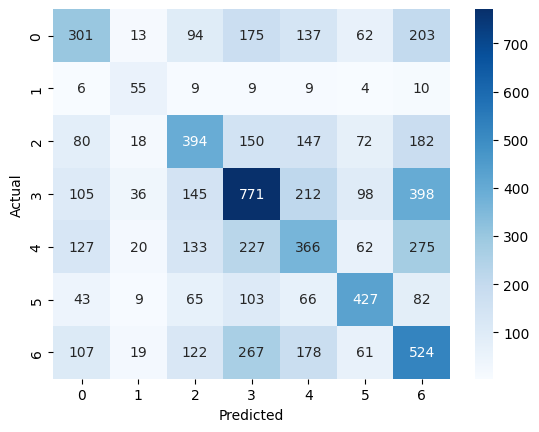

In [313]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', n_jobs=-1)
knn.fit(trainX, trainY)
knn_scores = evaluate_model(knn, testX, testY)

Accuracy: 0.46753970465310674
Precision: 0.5803767078938289
Recall: 0.4138465487952368
F1-Score: 0.43877822547918577

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.20      0.30       985
           1       1.00      0.26      0.42       102
           2       0.53      0.27      0.36      1043
           3       0.44      0.80      0.57      1765
           4       0.36      0.38      0.37      1210
           5       0.68      0.57      0.62       795
           6       0.46      0.40      0.43      1278

    accuracy                           0.47      7178
   macro avg       0.58      0.41      0.44      7178
weighted avg       0.50      0.47      0.45      7178


Confusion Matrix:


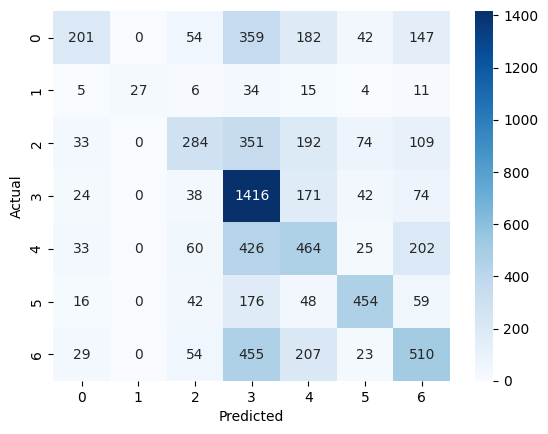

In [314]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=10, max_features='sqrt', max_depth=45, n_jobs=-1)
rf.fit(trainX, trainY)
rf_scores = evaluate_model(rf, testX, testY)

Accuracy: 0.3007801616049039
Precision: 0.23582548801856046
Recall: 0.24023627402054556
F1-Score: 0.2335267340186399

Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.12      0.14       985
           1       0.00      0.00      0.00       102
           2       0.20      0.12      0.15      1043
           3       0.37      0.54      0.44      1765
           4       0.25      0.25      0.25      1210
           5       0.37      0.36      0.37       795
           6       0.27      0.29      0.28      1278

    accuracy                           0.30      7178
   macro avg       0.24      0.24      0.23      7178
weighted avg       0.28      0.30      0.28      7178


Confusion Matrix:


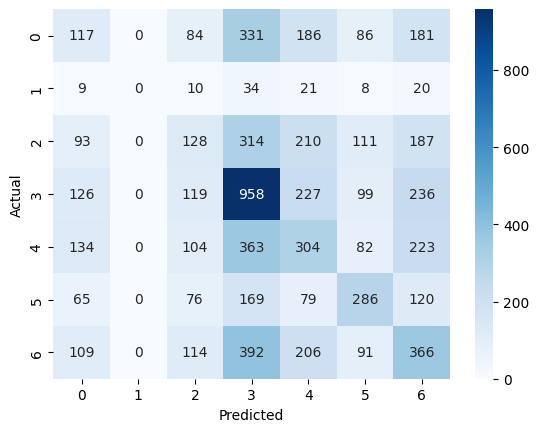

In [315]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=100)
dt.fit(trainX, trainY)
dt_scores = evaluate_model(dt, testX, testY)

Accuracy: 0.4100027862914461
Precision: 0.45066304029734183
Recall: 0.34170081541042135
F1-Score: 0.3426204748947304

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.18      0.22       985
           1       0.80      0.04      0.07       102
           2       0.30      0.28      0.29      1043
           3       0.53      0.65      0.58      1765
           4       0.30      0.37      0.33      1210
           5       0.52      0.51      0.52       795
           6       0.39      0.37      0.38      1278

    accuracy                           0.41      7178
   macro avg       0.45      0.34      0.34      7178
weighted avg       0.41      0.41      0.40      7178


Confusion Matrix:


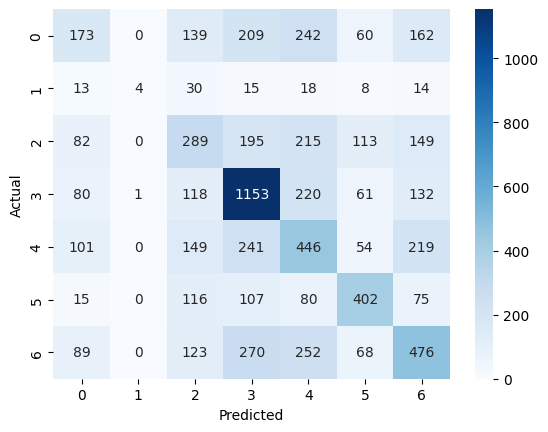

In [316]:
mlp = MLPClassifier(activation='tanh', 
                    hidden_layer_sizes= (100,), 
                    learning_rate= 'constant', 
                    solver= 'sgd')
mlp.fit(trainX, trainY)
mlp_scores = evaluate_model(mlp, testX, testY)

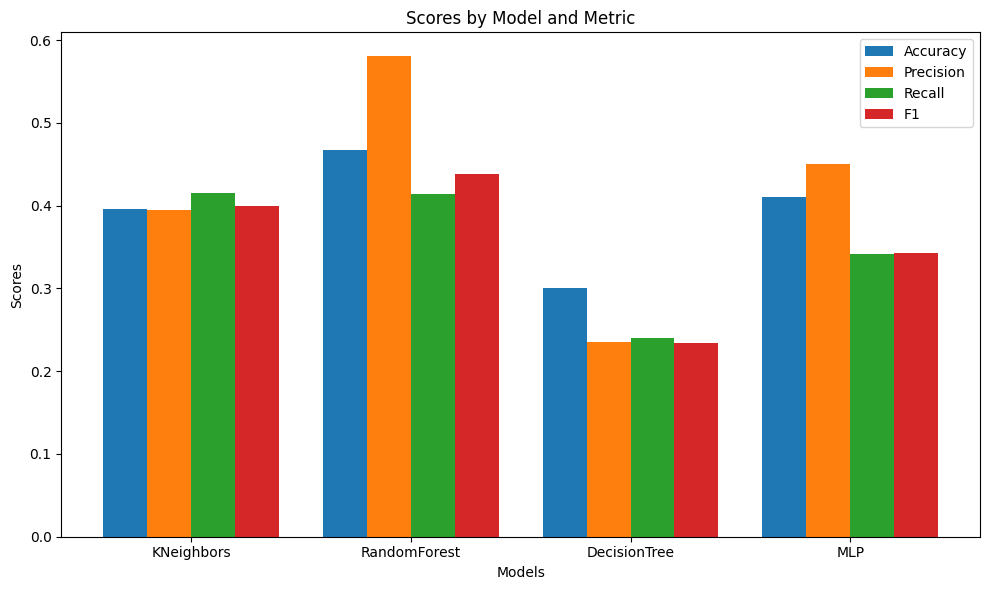

In [318]:
models = ['KNeighbors', 'RandomForest', 'DecisionTree', 'MLP']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
scores = [knn_scores, rf_scores, dt_scores, mlp_scores]

bar_width = 0.2
index = np.arange(len(models))
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(metrics)):
    ax.bar(index + i * bar_width, [score[i] for score in scores], bar_width, label=metrics[i])

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Scores by Model and Metric')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

## Identify the emotion category

In [252]:
images2, labels2 = parse_data(df)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

### Most Accurate Model: RandomForestClassifier

In [279]:
testX.shape

(7178, 2304)

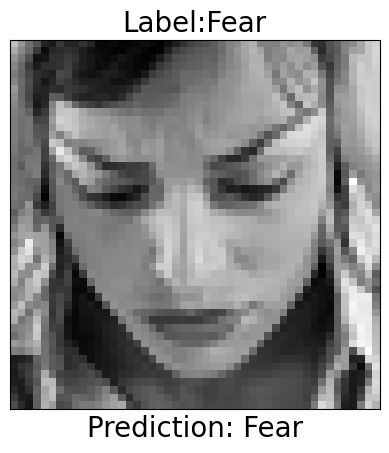

In [288]:
index = 7
predictions = rf.predict(testX)
textX_3d = testX.reshape((7178, 48, 48))

plt.figure()
plt.imshow(textX_3d[index], cmap='gray')
plt.title("Label:" + class_names[testY[index]], fontsize=20)
plt.xlabel("Prediction: " + class_names[predictions[index]], fontsize=20)
plt.xticks([])
plt.yticks([])
plt.show()

### Most Error Model: DecisionTreeClassifier

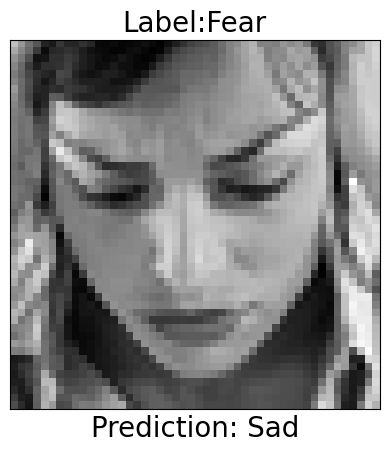

In [289]:
predictions = dt.predict(testX)
textX_3d = testX.reshape((7178, 48, 48))

plt.figure()
plt.imshow(textX_3d[index], cmap='gray')
plt.title("Label:" + class_names[testY[index]], fontsize=20)
plt.xlabel("Prediction: " + class_names[predictions[index]], fontsize=20)
plt.xticks([])
plt.yticks([])
plt.show()

# **EXTRA**: Using ```Tensorflow``` Library to build CNN Model

This is part of my self-study process. Seeing that the scores from four models above are not up to standard as the industry standards are between 70% and 90%. I want to try another way to get a higher accuracy score.

In [228]:
import tensorflow as tf
from tensorflow import keras

In [229]:
images2, labels2 = parse_data(df)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [230]:
train_images, test_images, train_labels, test_labels = train_test_split(images2, labels2, train_size=0.7, random_state=RANDOM_STATE)

In [231]:
train_images.shape, test_images.shape

((25120, 48, 48), (10767, 48, 48))

In [232]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [241]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [242]:
history = model.fit(x=train_images, y=train_labels, batch_size=128, epochs=15, validation_data=(test_images, test_labels))

Epoch 1/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 33s 141ms/step - accuracy: 0.2736 - loss: 1.7666 - val_accuracy: 0.4191 - val_loss: 1.5066
Epoch 2/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.4348 - loss: 1.4665 - val_accuracy: 0.4774 - val_loss: 1.3752
Epoch 3/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.4984 - loss: 1.3188 - val_accuracy: 0.5113 - val_loss: 1.2917
Epoch 4/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.5336 - loss: 1.2267 - val_accuracy: 0.5251 - val_loss: 1.2546
Epoch 5/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.5703 - loss: 1.1478 - val_accuracy: 0.5409 - val_loss: 1.2061
Epoch 6/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.6026 - loss: 1.0652 - val_accuracy: 0.5391 - val_loss: 1.2172
Epoch 7/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.6243 - loss: 0.9940 - val_accuracy: 0.5552 - val_loss: 1.1920
Epoch 8/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.6568 - loss: 0.9

In [243]:
test_lost, test_acc = model.evaluate(test_images, test_labels, verbose=1)
print('Test accuracy:', test_acc)

337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5633 - loss: 1.6767
Test accuracy: 0.5599517226219177


337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


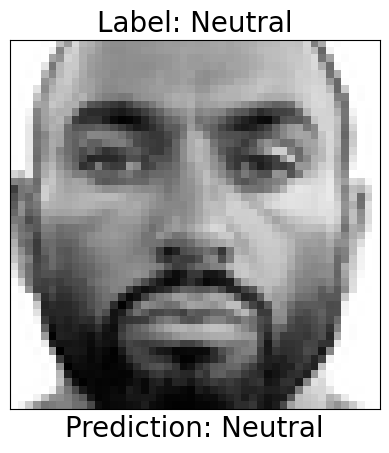

In [291]:
index = 10
predictions = model.predict(test_images)
plt.figure()
plt.imshow(test_images[index], cmap='gray')
plt.title("Label: " + class_names[test_labels[index]], fontsize=20)
plt.xlabel("Prediction: " + class_names[np.argmax(predictions[index])], fontsize=20)
plt.xticks([])
plt.yticks([])
plt.show()